In [55]:
from pyddeeg.utils.synthetic_signal_generator import synth_eeg, synth_signal
from pyddeeg.signal_processing.rqa_toolbox.rqa import plot_rqa

import os
from typing import Union, Optional, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries import RecurrencePlot
import scipy.stats as stats

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook"])
plt.rcParams.update({'figure.dpi': '50'})

Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...


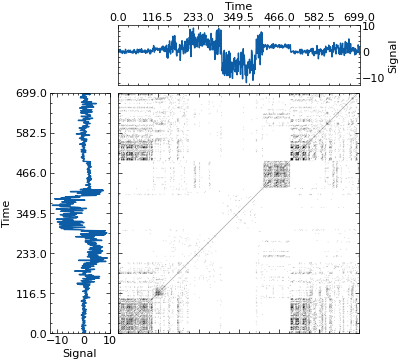

{'Recurrence Rate': np.float64(0.03303339053045541),
 'Determinism': np.float64(0.2548713951674104),
 'Laminarity': np.float64(0.39418416801267914),
 'Trapping Time': np.float64(2.5325349301296107)}

In [11]:
characteristics = {
    (0, 100): {"mean": 0, "std": 1},
    (101, 140): {"mean": 1, "std": 1},
    (141, 200): {"mean": 1, "std": 4},
    (201, 280): {"mean": 4, "std": 4},
    (281, 300): {"mean": 4, "std": 6},
    (301, 400): {"mean": -5, "std": 6},
    (401, 420): {"mean": 2, "std": 6},
    (421, 500): {"mean": 2, "std": 1},
    (501, 560): {"mean": 0, "std": 1},
    (561, 600): {"mean": 0, "std": 3},
    (601, 700): {"mean": 1, "std": 3},
}

# Generate the synthetic signal using scipy.stats.norm as the PDF.
timestamps, orig_sig, signal, results = synth_signal.synthetic_signal_gen(
    characteristics=characteristics,
    base_mean=0,
    base_std=0.5,
    pdf_function=stats.norm,
)

plot_rqa(data=signal, time=timestamps, dim=2, tau=2, threshold=0.5, metric="euclidean", show=True, save_path="./rqa_plot.svg", save_format="svg")

In a recurrence plot, a **cluster of black dots** generally indicates that a set of time points share very similar states (or values) over a certain interval. More specifically:

1. **Similarity Over a Time Window**  
   - Each black dot represents two time points (on the x-axis and y-axis) whose corresponding states are “close” in phase space.  
   - A cluster means many points in one time window are close to many points in another time window—suggesting a recurring pattern or “regime” in the signal.

2. **Repeated Patterns**  
   - If the cluster appears away from the main diagonal, it implies the system (or signal) revisited a previously observed state at a later time.  
   - If the cluster is near the diagonal, it often indicates the system stayed in a similar state for an extended duration (sometimes seen as laminar or quasi-stationary behavior).

3. **Context-Dependent Meaning**  
   - In EEG, for instance, a cluster of black dots might mean the brain activity entered a similar oscillatory or functional state at different times.  
   - In other applications (e.g., climate, stock data), it could reflect recurring patterns such as seasonal cycles, repeated market conditions, etc.

In short, **clusters of black dots** on a recurrence plot usually signify intervals where the system returns to (or remains in) a similar dynamical regime. By examining when and where these clusters occur, you can gain insights into the periodicity, stationarity, or repetitive nature of your time series.

[INFO] Synthetic signal generated.
       Length of raw signal = 700 samples.
[INFO] Window variance range: [0.17876483977746585, 34.5577690203412]
[INFO] RQA time series computed.
       RQA matrix shape = (T=651, L=6).
       -> So we have 651 time points of RQA, each with 6 metrics.


/tmp/ipykernel_24497/3090337891.py:184: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = stats.spearmanr(sub_block_T[l1, :], sub_block_T[l2, :])


[INFO] rqa_space_window_size=100 => we get Q=552 windows in the RQA domain.


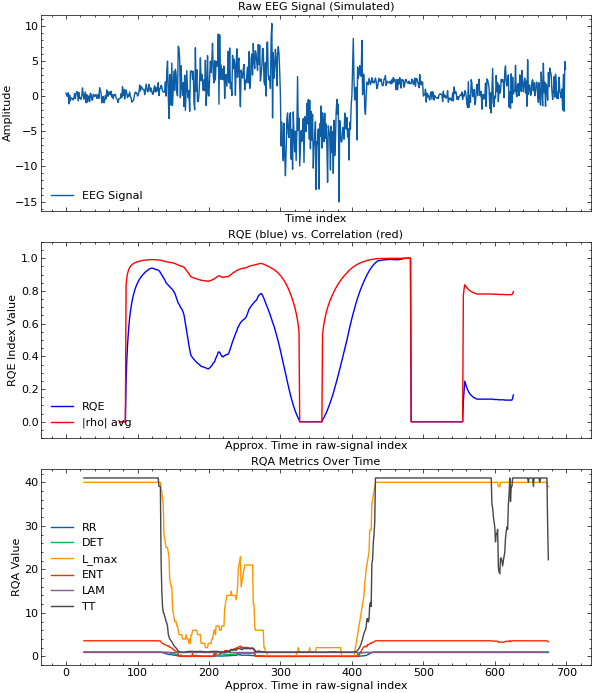

In [86]:
#!/usr/bin/env python3
"""
replicate_rqe_paper.py

Attempt to replicate the paper's two-stage logic for computing an RQE
index from a single EEG signal, using the parameters from Table 3:

Embedding = 10
Radius = 80
Line = 5
Shift = 1
Epoch = 50
Distance = Meandist, Euclidean
No. of epochs = 642  (depends on actual signal length)

Stage 1:  Compute a time series for each RQA measure by sliding a small
          window of size = Epoch (50) across the raw EEG.
Stage 2:  Define bigger "rolling windows" across the RQA-measure domain,
          compute pairwise Spearman correlations among those sub-segments,
          then do the product (1 + |rho|).
"""

import numpy as np
from typing import List, Tuple, Any
import scipy.stats as stats
import matplotlib.pyplot as plt

from pyddeeg.utils.synthetic_signal_generator.synth_signal import synthetic_signal_gen


# If needed, install pyunicorn: pip install pyunicorn
try:
    from pyunicorn.timeseries import RecurrencePlot
except ImportError:
    RecurrencePlot = None
    print("[DEBUG] pyunicorn not installed. Install via: pip install pyunicorn")


###############################################################################
# Helper Functions
###############################################################################


def compute_rqa_metrics_for_window(
    window_signal: np.ndarray,
    embedding_dim: int,
    time_delay: int,
    radius: float,
    distance_metric: str,
    min_diagonal_line: int = 2,
    min_vertical_line: int = 2,
    min_white_vertical_line: int = 1,
) -> dict:
    """
    Compute comprehensive RQA metrics from a single window of the raw EEG signal
    using pyunicorn's RecurrencePlot.
    """
    if RecurrencePlot is None:
        raise ImportError(
            "pyunicorn is not available. Install with pip install pyunicorn."
        )

    if distance_metric.lower() == "meandist":
        # Calculate pairwise distances
        from scipy.spatial.distance import pdist

        distances = pdist(window_signal.reshape(-1, 1), metric="euclidean")
        mean_dist = np.mean(distances)
        # Normalize radius by mean distance
        normalized_radius = radius / mean_dist
        actual_radius = normalized_radius
        distance_metric = "euclidean"
    else:
        actual_radius = radius

    rp = RecurrencePlot(
        time_series=window_signal,
        dim=embedding_dim,
        tau=time_delay,
        metric=distance_metric,
        threshold=actual_radius,
        silence_level=2,
    )

    # Compute all available RQA metrics
    metrics = {
        "RR": rp.recurrence_rate(),
        "DET": rp.determinism(l_min=min_diagonal_line),
        "L_max": rp.max_diaglength(),
        "L_mean": rp.average_diaglength(l_min=min_diagonal_line),
        "ENT": rp.diag_entropy(l_min=min_diagonal_line),
        "LAM": rp.laminarity(v_min=min_vertical_line),
        "TT": rp.trapping_time(v_min=min_vertical_line),
        # Additional line-based measures
        "V_max": rp.max_vertlength(),
        "V_mean": rp.average_vertlength(v_min=min_vertical_line),
        "V_ENT": rp.vert_entropy(v_min=min_vertical_line),
        # White vertical line measures
        "W_max": rp.max_white_vertlength(),
        "W_mean": rp.average_white_vertlength(w_min=min_white_vertical_line),
        "W_ENT": rp.white_vert_entropy(w_min=min_white_vertical_line),
        # Complexity measures (only if pyunicorn version supports them)
        "CLEAR": rp.complexity_entropy() if hasattr(rp, "complexity_entropy") else None,
        "PERM_ENT": (
            rp.permutation_entropy() if hasattr(rp, "permutation_entropy") else None
        ),
    }

    return metrics


def compute_rqa_time_series(
    signal: np.ndarray,
    raw_signal_window_size: int,
    embedding_dim: int,
    time_delay: int,
    radius: float,
    distance_metric: str,
    min_diagonal_line: int,
    min_vertical_line: int,
    min_white_vertical_line: int,
    metrics_to_use: List[str],
    stride: int = 0,  # If stride == 0 then we are replicating the exact RQE definition from the paper.
) -> np.ndarray:
    """
    Slide a small window of size 'raw_signal_window_size' over the raw signal, compute RQA
    metrics for each position, and return them as a 2D array of shape (T, L).
    """
    n = len(signal)
    num_positions = (n - raw_signal_window_size) // stride + 1
    rqa_results = []

    for i in range(num_positions):
        start_idx = i * stride
        window_data = signal[start_idx : start_idx + raw_signal_window_size]
        rqa_vals = compute_rqa_metrics_for_window(
            window_signal=window_data,
            embedding_dim=embedding_dim,
            time_delay=time_delay,
            radius=radius,
            distance_metric=distance_metric,
            min_diagonal_line=min_diagonal_line,
            min_vertical_line=min_vertical_line,
            min_white_vertical_line=min_white_vertical_line,
        )

        # Extract only the metrics we asked for
        values_of_interest = []
        for key in metrics_to_use:
            values_of_interest.append(rqa_vals.get(key))
        rqa_results.append(values_of_interest)

    return np.array(rqa_results)


def compute_rqe_and_correlation(
    rqa_matrix: np.ndarray, rqa_space_window_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute two measures for each 'big window' in the RQA time series:
      1) RQE = product of (1 + |rho|)
      2) Corr = average of |rho|
    """
    T, L = rqa_matrix.shape
    if rqa_space_window_size > T:
        raise ValueError(
            "rqa_space_window_size cannot exceed the length of the RQA time series."
        )

    Q = T - rqa_space_window_size + 1
    rqe_list = []
    corr_list = []

    for start_idx in range(Q):
        sub_block = rqa_matrix[start_idx : start_idx + rqa_space_window_size, :]
        # shape = (rqa_space_window_size, L)
        # We'll treat each column as a sub-series of length rqa_space_window_size
        sub_block_T = sub_block.T

        # Collect pairwise correlations
        pairwise_rho = []
        for l1 in range(L):
            for l2 in range(l1 + 1, L):
                rho, _ = stats.spearmanr(sub_block_T[l1, :], sub_block_T[l2, :])
                pairwise_rho.append(abs(rho))

        if len(pairwise_rho) == 0:
            # If L < 2
            rqe_val = 1.0
            corr_val = 0.0
        else:
            # RQE = product(1 + |rho|)
            product_val = 1.0
            for c in pairwise_rho:
                product_val *= 1.0 + c
            rqe_val = product_val

            # Corr = mean(|rho|)
            corr_val = np.mean(pairwise_rho)

        rqe_list.append(rqe_val)
        corr_list.append(corr_val)

    return np.array(rqe_list), np.array(corr_list)


def min_max_normalize(array: np.ndarray) -> np.ndarray:
    """
    Scale the values of 'array' into [0, 1] by min-max normalization.
    If all values are the same, the result is an array of zeros.
    """
    array = np.nan_to_num(x=array)

    min_val = np.min(array)
    max_val = np.max(array)

    if max_val > min_val:
        return (array - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(array)


###############################################################################
# Main demonstration function
###############################################################################


def main(
    embedding_dim: int = 10,
    radius: Any = 80.0,
    time_delay: int = 1,
    raw_signal_window_size: int = 50,
    distance_metric: str = "euclidean",
    rqa_space_window_size: int = 100,
    simulate_length: int = 700,
    min_diagonal_line: int = 5,
    min_vertical_line: int = 1,
    min_white_vertical_line: int = 1,
    metrics_to_use: List[str] = ["RR", "DET", "L_max", "ENT", "LAM", "TT"],
    stride: int = 0,
):
    """
    Demonstration function that:
      1) Generates a synthetic EEG signal of length 'simulate_length' with variability.
      2) Computes an RQA time series using 'raw_signal_window_size' as the rolling window on the raw signal.
      3) Computes RQE & Corr for a larger window of size 'rqa_space_window_size' sliding over the RQA domain.
      4) Plots:
         - Raw EEG signal
         - RQE vs. correlation
         - Time series of each RQA metric in metrics_to_use
    """
    # ------------------------------------------------------------------
    # 1) Generate a synthetic raw signal with some variability
    characteristics = {
        (0, 100): {"mean": 0, "std": 1},
        (101, 140): {"mean": 1, "std": 1},
        (141, 200): {"mean": 1, "std": 4},
        (201, 280): {"mean": 4, "std": 4},
        (281, 300): {"mean": 4, "std": 6},
        (301, 400): {"mean": -5, "std": 6},
        (401, 420): {"mean": 2, "std": 6},
        (421, 500): {"mean": 2, "std": 1},
        (501, 560): {"mean": 0, "std": 1},
        (561, 600): {"mean": 0, "std": 3},
        (601, 700): {"mean": 1, "std": 3},
    }

    # Generate the synthetic signal using scipy.stats.norm as the PDF.
    t, orig_sig, raw_signal, results = synthetic_signal_gen(
        characteristics=characteristics,
        base_mean=0,
        base_std=0.5,
        pdf_function=stats.norm,
    )

    print("[INFO] Synthetic signal generated.")
    print(f"       Length of raw signal = {simulate_length} samples.")

    # Replace the fixed radius with a percentage of the signal's range
    if isinstance(radius, float) and radius > 1.0:
        # If radius is large, interpret as percentage of range
        signal_range = np.max(raw_signal) - np.min(raw_signal)
        actual_radius = (radius / 100.0) * signal_range
    else:
        actual_radius = radius
    radius = actual_radius
    # ------------------------------------------------------------------
    # 2) Compute RQA time series
    rqa_matrix = compute_rqa_time_series(
        signal=raw_signal,
        raw_signal_window_size=raw_signal_window_size,
        embedding_dim=embedding_dim,
        time_delay=time_delay,
        radius=radius,
        distance_metric=distance_metric,
        min_diagonal_line=min_diagonal_line,
        min_vertical_line=min_vertical_line,
        min_white_vertical_line=min_white_vertical_line,
        metrics_to_use=metrics_to_use,
        stride=stride,
    )

    window_variances = []
    for start_idx in range(rqa_matrix.shape[0]):
        window_data = raw_signal[start_idx : start_idx + raw_signal_window_size]
        window_variances.append(np.var(window_data))

    print(
        f"[INFO] Window variance range: [{min(window_variances)}, {max(window_variances)}]"
    )

    T, L = rqa_matrix.shape
    print("[INFO] RQA time series computed.")
    print(f"       RQA matrix shape = (T={T}, L={L}).")
    print(f"       -> So we have {T} time points of RQA, each with {L} metrics.")
    if T <= 1:
        print("[WARNING] T <= 1. Not enough RQA points to form correlations.")

    if L < 2:
        print(
            "[WARNING] L < 2. You only have one metric, so correlation is not meaningful."
        )

    # ------------------------------------------------------------------
    # 3) Compute RQE & Corr in the RQA domain
    #    (the 'big window' for correlation must be <= T)
    if rqa_space_window_size > T:
        print(
            f"[WARNING] rqa_space_window_size={rqa_space_window_size} is larger than T={T}. Adjusting."
        )
        rqa_space_window_size = T

    rqe_vals, corr_vals = compute_rqe_and_correlation(
        rqa_matrix, rqa_space_window_size=rqa_space_window_size
    )
    Q = len(rqe_vals)

    # Provide guidance if Q is tiny
    print(
        f"[INFO] rqa_space_window_size={rqa_space_window_size} => we get Q={Q} windows in the RQA domain."
    )
    if Q < 2:
        print(
            "[WARNING] Q < 2. You only have one 'big window', so RQE/corr won't vary over time."
        )
        print(
            "          Try decreasing rqa_space_window_size or increasing the raw signal length or raw_signal_window_size."
        )

    # Build an approximate x-axis for the RQA-based series
    # For each RQA index i, approximate mapping to raw-signal domain
    # i -> i + raw_signal_window_size/2
    # For RQE/corr, each big window is rqa_space_window_size wide, so center is i + rqa_space_window_size/2
    big_half = rqa_space_window_size / 2.0
    rqe_time = []
    for i in range(Q):
        center_rqa = i + big_half
        # Approx mapping to raw-signal time index
        approx_raw = center_rqa + raw_signal_window_size / 2.0
        if approx_raw < simulate_length:
            rqe_time.append(approx_raw)
        else:
            rqe_time.append(simulate_length - 1)
    rqe_time = np.array(rqe_time)  # type: ignore

    # Normalize RQE & Corr
    rqe_norm = min_max_normalize(rqe_vals)
    corr_norm = min_max_normalize(corr_vals)

    # ------------------------------------------------------------------
    # 4) Plot
    #    We'll create 3 subplots:
    #       (a) raw EEG
    #       (b) RQE vs. correlation
    #       (c) each RQA metric vs. time
    #    For the RQA time, we similarly define an approximate X axis.
    #    For T points, we shift them by ~ raw_signal_window_size/2 to map to raw-signal domain.
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

    # (a) Raw EEG
    ax_signal = axes[0]
    ax_signal.set_title("Raw EEG Signal (Simulated)")
    ax_signal.plot(t, raw_signal, label="EEG Signal")
    ax_signal.set_xlabel("Time index")
    ax_signal.set_ylabel("Amplitude")
    ax_signal.legend(loc="lower left")

    # (b) RQE (blue) vs. correlation (red)
    ax_rqe = axes[1]
    ax_rqe.set_title(
        f"RQE (blue) vs. Correlation (red)"
    )
    ax_rqe.plot(rqe_time, rqe_norm, label="RQE", color="blue")
    ax_rqe.plot(rqe_time, corr_norm, label="|rho| avg", color="red")
    ax_rqe.set_xlabel("Approx. Time in raw-signal index")
    ax_rqe.set_ylabel("RQE Index Value")
    ax_rqe.legend(loc="lower left")
    ax_rqe.set_ylim([-0.1, 1.1])

    # (c) Plot each RQA metric over time
    ax_rqa = axes[2]
    ax_rqa.set_title("RQA Metrics Over Time")
    # Approx. mapping for each of the T points in the RQA domain
    rqa_time = np.arange(T) + (raw_signal_window_size / 2.0)

    for m_idx, metric_name in enumerate(metrics_to_use):
        ax_rqa.plot(rqa_time, rqa_matrix[:, m_idx], label=metric_name)

    ax_rqa.set_xlabel("Approx. Time in raw-signal index")
    ax_rqa.set_ylabel("RQA Value")
    ax_rqa.legend(loc="best")

    plt.tight_layout()
    # plt.savefig("scripts/rqe_analysis_with_metrics.svg")
    plt.show()


# ------------------------------------------------------------------------
# Example usage:
# ------------------------------------------------------------------------
if __name__ == "__main__":
    main(
        embedding_dim=10,  # "Embedding"
        radius=80.0,  # "Radius"
        time_delay=1,  # "Shift"
        raw_signal_window_size=50,  # "Epoch"
        distance_metric="meandist",  # "Distance"
        min_diagonal_line=5,  # "Line"
        min_vertical_line=1,
        min_white_vertical_line=1,
        rqa_space_window_size=100,  # Big window for correlation in RQA domain
        simulate_length=700,  # Enough length to produce some variety
        stride=1
    )


- Epoch Size. 
  - The epoch size (set to 50 in your code) determines the window size for the first stage of computation:
  - It defines how many raw signal data points are used to compute a single set of RQA metrics
  - This window slides across your raw EEG signal
  - For each position of this window, you compute RQA metrics (RR, DET, L_max, etc.)
  - The output is a time series of RQA metrics, where each time point represents the RQA values for a window of size raw_signal_window_size
  - Think of this as: "How much raw signal do I need to meaningfully compute recurrence properties?"
- Big Window Size
  - The big window size (set to 100 in your code) applies to the second stage of computation:
  - It operates on the RQA time series that resulted from the first stage
  - It determines how many consecutive RQA metric points will be considered together when computing correlations
  - For each "big window," you calculate Spearman correlations between pairs of RQA metrics
  - The RQE is calculated as the product of (1 + |rho|) for all these correlations
  - Think of this as: "How many RQA points do I need to meaningfully compute correlations between metrics?"

/tmp/ipykernel_24497/329578689.py:144: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(sub_block_T[l1, :], sub_block_T[l2, :])


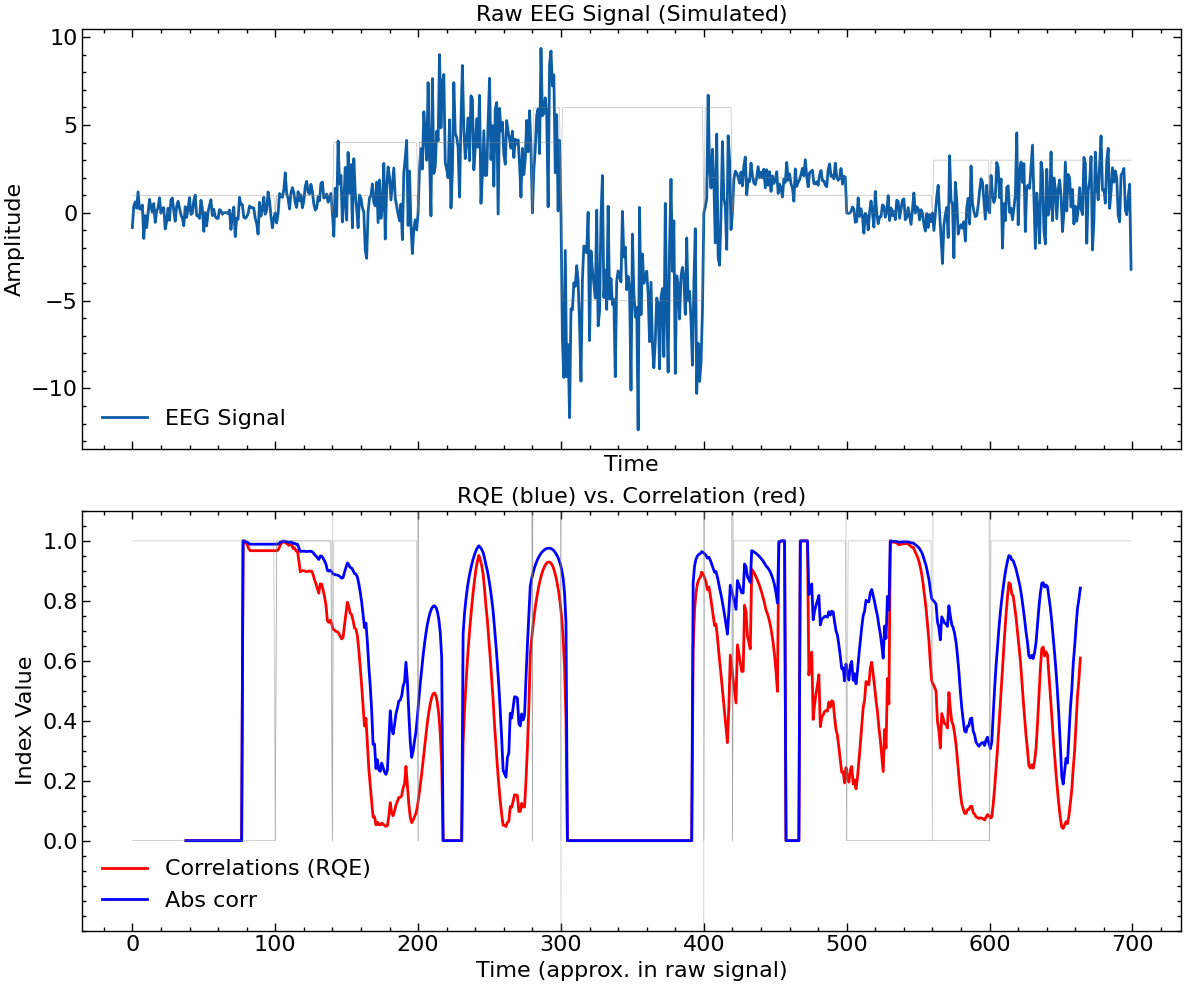

In [ ]:


characteristics = {
    (0, 100): {"mean": 0, "std": 1},
    (101, 140): {"mean": 1, "std": 1},
    (141, 200): {"mean": 1, "std": 4},
    (201, 280): {"mean": 4, "std": 4},
    (281, 300): {"mean": 4, "std": 6},
    (301, 400): {"mean": -5, "std": 6},
    (401, 420): {"mean": 2, "std": 6},
    (421, 500): {"mean": 2, "std": 1},
    (501, 560): {"mean": 0, "std": 1},
    (561, 600): {"mean": 0, "std": 3},
    (601, 700): {"mean": 1, "std": 3},
}

# Generate the synthetic signal using scipy.stats.norm as the PDF.
timestamps, orig_sig, raw_signal, results = synth_signal.synthetic_signal_gen(
    characteristics=characteristics,
    base_mean=0,
    base_std=0.5,
    pdf_function=stats.norm,
)